# Comparing data loading speeds with `kvikIO` and `Zarr` engine

Benchmark details:
- Loading a 1 year subset of the WeatherBench2 (~18.2GB)
- Calculate median time to load entire dataset in 23 mini-batches (of batch size 32),
  across 10 epochs.

In [1]:
import importlib
import time

import lightning as L
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange

module = importlib.import_module(name="1_benchmark_kvikIOzarr")

In [2]:
# Empty dataframe to store results
df = pd.DataFrame()
# Optimize torch performance
torch.set_float32_matmul_precision(precision="medium")

In [3]:
# Training loop data loading function
def training_loop(train_dataloader) -> list[float]:
    epoch_timings: list = []
    for epoch in trange(10):
        # Start timing
        tic: float = time.perf_counter()

        # Mini-batch processing
        for i, batch in tqdm(iterable=enumerate(train_dataloader), total=23):
            input, target, metadata = batch
            # Compute Mean Squared Error loss between t=0 and t=1, just for fun
            loss: torch.Tensor = torch.functional.F.mse_loss(input=input, target=target)
            # print(f"Batch {i}, MSE Loss: {loss}")

        # Stop timing
        toc: float = time.perf_counter()
        epoch_timings.append(toc - tic)
    return epoch_timings

## kvikIO engine

In [4]:
# Setup data
datamodule: L.LightningDataModule = module.WeatherBench2DataModule(engine="kvikio")
datamodule.setup()
train_dataloader = datamodule.train_dataloader()

Loading data using kvikio engine


In [5]:
# Training loop
epoch_timings: list[float] = training_loop(train_dataloader=train_dataloader)
df["kvikio"] = epoch_timings

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [6]:
# Report timings
total_time: float = df.kvikio.sum()
median_time: float = df.kvikio.median()
mean_time: float = df.kvikio.mean()
std_time: float = df.kvikio.std()
print(
    f"Total: {total_time:0.4f} seconds, "
    f"Median: {median_time:0.4f} seconds/epoch, "
    f"Mean: {mean_time:0.4f} ± {std_time:0.4f} seconds/epoch"
)

Total: 121.5782 seconds, Median: 11.8606 seconds/epoch, Mean: 12.1578 ± 0.8311 seconds/epoch


## Zarr engine

In [7]:
# Setup data
datamodule: L.LightningDataModule = module.WeatherBench2DataModule(engine="zarr")
datamodule.setup()
train_dataloader = datamodule.train_dataloader()

Loading data using zarr engine


In [8]:
# Training loop
epoch_timings: list[float] = training_loop(train_dataloader=train_dataloader)
df["zarr"] = epoch_timings

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [9]:
# Report timings
total_time: float = df.zarr.sum()
median_time: float = df.zarr.median()
mean_time: float = df.zarr.mean()
std_time: float = df.zarr.std()
print(
    f"Total: {total_time:0.4f} seconds, "
    f"Median: {median_time:0.4f} seconds/epoch, "
    f"Mean: {mean_time:0.4f} ± {std_time:0.4f} seconds/epoch"
)

Total: 159.2952 seconds, Median: 16.0240 seconds/epoch, Mean: 15.9295 ± 0.3761 seconds/epoch


## Summary results

Show time difference of using GPUDirect Storage `kvikio` engine vs CPU-based `zarr` engine.

In [10]:
# kivkIO engine should take less time than Zarr engine
assert df.kvikio.median() < df.zarr.median()

In [11]:
time_diff: float = (df.zarr.median() - df.kvikio.median()) / df.zarr.median()
print(f"kvikIO engine uses {time_diff * 100:0.2f}% less time than Zarr engine")

kvikIO engine uses 25.98% less time than Zarr engine


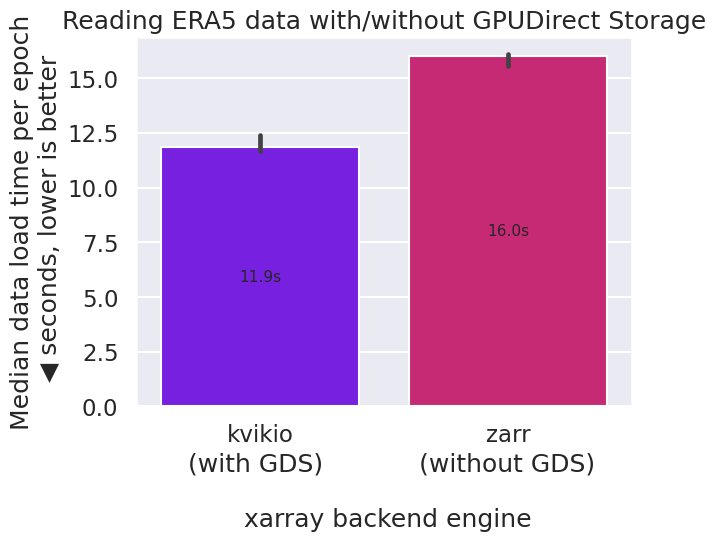

In [12]:
sns.set_theme(context="talk", palette=["#7400ff", "#e01073"])
ax = sns.barplot(data=df, estimator="median")
for container in ax.containers:
    ax.bar_label(container=container, fontsize=11, fmt="%.1fs", label_type="center")
ax.set_ylabel(ylabel="Median data load time per epoch\n ◀ seconds, lower is better")
ax.set_xlabel(
    xlabel="   (with GDS)            (without GDS) \n\n xarray backend engine"
)
ax.set_title(label="Reading ERA5 data with/without GPUDirect Storage")
fig = ax.get_figure()
fig.savefig(fname="figures/compare_kvikio_zarr.svg", bbox_inches="tight")